# F-scale-test: This Notebook trains the NOIRE-Net F-region scaling networks

## 1 - Import libaries

In [1]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import random

## 2 - Define a function to get ionogram scaling parameters from the testing data 

In [2]:
# The function get_regression_label_from_par reads a .par file and returns 
# the F-region maximum O-mode frequency and the F-region height.
# Both the foF and hF must be values (can not be 'nan'). 

def get_regression_label_from_par(par_file_path):
    try:
        # Open the file at the specified path
        with open(par_file_path, 'r') as file:
            content = file.readline().strip()  # Read the first line and remove leading/trailing whitespace
            items = content.split()  # Split the line into individual items

            # Check if both the first and third items are not 'nan' (not a number)
            # If they are both valid numbers, convert them to floats and return them as a tuple
            if items[0].lower() != 'nan' and items[2].lower() != 'nan':
                return float(items[0]), float(items[2])
            else:
                # If either item is 'nan', return None
                return None
    except Exception as e:
        # Print an error message if an exception occurs while processing the file
        print(f"Error reading {par_file_path}: {e}")
        # Return None if there is an error
        return None


## 3 - Define functions to load and process test images

In [3]:
# The load_data function loads and preprocesses image data from a specified directory,
# converting images to grayscale and resizing them, while also extracting corresponding
# scaling parameters from associated .par files for a regression task.

def load_data(data_dir, target_size=(310, 310)):
    images = []  # List to store preprocessed images
    labels = []  # List to store corresponding regression labels

    # Construct paths to the directories containing ionograms and parameters
    ionograms_dir = os.path.join(data_dir, 'ionograms')
    parameters_dir = os.path.join(data_dir, 'parameters')

    # Iterate over the files in the ionograms directory
    for filename in os.listdir(ionograms_dir):
        if filename.endswith('.png'):  # Check if the file is a PNG image
            # Construct full paths to the image file and its corresponding .par file
            img_path = os.path.join(ionograms_dir, filename)
            par_path = os.path.join(parameters_dir, filename.replace('.png', '.par'))

            # Load the image, convert it to grayscale, resize it, and normalize pixel values
            image = load_img(img_path, color_mode='grayscale', target_size=target_size)
            image = img_to_array(image) / 255.0  # Normalize image pixels to be between 0 and 1

            # Get the regression labels from the .par file
            regression_label = get_regression_label_from_par(par_path)
            
            # Proceed only if valid regression labels are found
            if regression_label is not None:
                images.append(image)
                labels.append(regression_label)

    # Convert the lists of images and labels to numpy arrays and return them
    return np.array(images), np.array(labels)

## 4 - Extract testing images and scaling parameters from human experts

In [4]:
# Specify the directory where the data is stored
data_dir = 'train-val-test'  # 'train_test_val' should be replaced with the actual path to your data directory

# Call the load_data function to load and preprocess the data
# X contain the preprocessed images, and y will contain the corresponding labels
X, y = load_data(data_dir)

## 5 - Load the trained models and evaluate the performance on the testing data 

In [5]:
# This code calculates and prints regression performance metrics (Root Mean Squared Error and 
# Median Absolute Distance) for two sets of true and predicted values, specifically for the
# F-region maximum frequency and the F-region height.

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, scale_factor=1.0):
    """
    Calculate metrics for a given set of true and predicted values.
    Args:
    y_true (array): The true values.
    y_pred (array): The predicted values.
    scale_factor (float): Scale factor for RMSE.
    Returns:
    A dictionary containing RMSE and MAD metrics.
    """
    rmse = sqrt(mean_squared_error(y_true, y_pred)) * scale_factor
    mad = np.median(np.abs(y_true - y_pred)) * scale_factor
    return {'rmse': rmse, 'mad': mad}

# Directory where models are saved
model_dir = 'F-scale'

# Define scale factors
dF = 50     # The frequency resolution is 50 kHz/pixel
dZ = 4.1935 # The virtual height resolution is 4.1935 km/pixel

# Initialize lists to store metrics for all models
all_freq_rmse, all_height_rmse = [], []
all_freq_mad, all_height_mad = [], []

# Load models and evaluate
for i in range(10):
    
    # Use the same random state as in training for consistent test set
    _, X_temp, _, y_temp = train_test_split(X, y, test_size=0.3, random_state=i)
    _, X_test, _, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=i)

    # Load the trained model
    model_path = os.path.join(model_dir, f'F-scale_run{i+1}.h5')
    model = load_model(model_path)

    # Predict on the test data
    predictions = model.predict(X_test)
    model_path = os.path.join(model_dir, f'F-scale_run{i+1}.h5')
    model = load_model(model_path)
    predictions = model.predict(X_test)

    # Extract frequency and height predictions
    predictions_freq = predictions[:, 0]
    predictions_height = predictions[:, 1]

    # Extract true frequency and height values
    y_test_freq = y_test[:, 0]
    y_test_height = y_test[:, 1]

    # Calculate metrics
    freq_metrics = calculate_metrics(y_test_freq, predictions_freq, dF)
    height_metrics = calculate_metrics(y_test_height, predictions_height, dZ)

    # Append metrics to respective lists
    all_freq_rmse.append(freq_metrics['rmse'])
    all_height_rmse.append(height_metrics['rmse'])
    all_freq_mad.append(freq_metrics['mad'])
    all_height_mad.append(height_metrics['mad'])

# Calculate mean and standard deviation
mean_freq_rmse, std_freq_rmse = np.mean(all_freq_rmse), np.std(all_freq_rmse)
mean_height_rmse, std_height_rmse = np.mean(all_height_rmse), np.std(all_height_rmse)
mean_freq_mad, std_freq_mad = np.mean(all_freq_mad), np.std(all_freq_mad)
mean_height_mad, std_height_mad = np.mean(all_height_mad), np.std(all_height_mad)

# Print the results with standard deviation
print(f"F-region maximum frequency [kHz]: RMSE = {mean_freq_rmse:.2f} ± {std_freq_rmse:.2f}, MAD = {mean_freq_mad:.2f} ± {std_freq_mad:.2f}")
print(f"F-region height [km]: RMSE = {mean_height_rmse:.2f} ± {std_height_rmse:.2f}, MAD = {mean_height_mad:.2f} ± {std_height_mad:.2f}")

Metal device set to: Apple M1 Max


2023-12-03 14:59:26.374625: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-03 14:59:26.374774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-03 14:59:27.230724: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-03 14:59:27.348684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 71ms/step


2023-12-03 14:59:31.148856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 2s 40ms/step


2023-12-03 14:59:34.185609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 71ms/step


2023-12-03 14:59:37.767236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 66ms/step


2023-12-03 14:59:42.934190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 63ms/step


2023-12-03 14:59:46.160791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 77ms/step


2023-12-03 14:59:52.215297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 71ms/step


2023-12-03 14:59:56.117906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 2s 52ms/step


2023-12-03 15:00:01.646959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 4s 93ms/step


2023-12-03 15:00:07.594629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 4s 72ms/step


2023-12-03 15:00:12.725024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 72ms/step


2023-12-03 15:00:16.238664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 78ms/step


2023-12-03 15:00:21.383341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 63ms/step


2023-12-03 15:00:24.743539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 74ms/step


2023-12-03 15:00:31.312061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 80ms/step


2023-12-03 15:00:35.524859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 2s 48ms/step


2023-12-03 15:00:41.872706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 4s 90ms/step


2023-12-03 15:00:46.340587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 2s 44ms/step


2023-12-03 15:00:51.152835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 76ms/step


2023-12-03 15:00:54.984766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 66ms/step
F-region maximum frequency [kHz]: RMSE = 267.07 ± 45.89, MAD = 88.32 ± 9.54
F-region height [km]: RMSE = 33.21 ± 2.87, MAD = 8.74 ± 1.53


## 6 - Define function to extract testing images and scaling parameters from multi-human data set

In [6]:
# The load_data function loads and preprocesses image data from a specified directory,
# converting images to grayscale and resizing them, while also extracting corresponding
# scaling parameters from associated .par files for a regression task.

def load_data_experts(data_dir, experts, target_size=(310, 310)):
    images = []  # List to store preprocessed images
    labels = []  # List to store corresponding regression labels
    timestamps = []  # List to store timestamps for each image

    ionograms_dir = os.path.join(data_dir, 'ionograms')
    parameters_dir = os.path.join(data_dir, 'parameters')

    # Function to load and preprocess an image
    def load_and_preprocess_image(image_path):
        # Load the image file, resize it, and convert it to grayscale
        image = load_img(image_path, target_size=target_size, color_mode='grayscale')
        # Convert the image to a numpy array and normalize it
        image = img_to_array(image) / 255.0
        return image

    # Iterate over the files in the ionograms directory
    for filename in os.listdir(ionograms_dir):
        if filename.endswith('.png'):
            img_path = os.path.join(ionograms_dir, filename)
            # Extract timestamp without expert prefix
            timestamp = os.path.splitext(filename)[0]
            for expert in experts:
                if timestamp.startswith(expert + '-'):
                    timestamp = timestamp[len(expert) + 1:]  # Remove expert prefix and '-'
                    break
            timestamps.append(timestamp)

            # Collect labels from all experts for this image
            expert_labels = []
            for expert in experts:
                par_path = os.path.join(parameters_dir, f"{expert}-{timestamp}.par")
                if os.path.exists(par_path):
                    label = get_regression_label_from_par(par_path)
                    if label is not None:
                        expert_labels.append(label)

            # Proceed only if there are labels from experts
            if expert_labels:
                image = load_and_preprocess_image(img_path)
                images.append(image)
                # Calculate the median label across experts for this image
                labels.append(np.median(expert_labels, axis=0))

    # Convert the lists of images and labels to numpy arrays and return them
    return np.array(images), np.array(labels), timestamps

## 7 - Load the multi-human testing data

In [7]:
# Assuming you have a function to load test data
# X_test contains test images, and y_test contains corresponding human labels
experts = ['akv', 'trx', 'dhu', 'jvi', 'asp']
X_test, y_test, image_timestamps = load_data_experts('test-multi-human', experts)

## 8 - Load the trained models with the lowest validation loss 

In [8]:
# Assuming models are named 'F-scale-run1' to 'F-scale-run10' and saved in the 'F-scale' directory
model_dir = 'F-scale'
model_names = [f'F-scale_run{i}' for i in range(1, 11)]
models = []

# Load all models
for model_name in model_names:
    model_path = os.path.join(model_dir, model_name + '.h5')  # Adjust extension based on how models are saved
    models.append(load_model(model_path))

## 9 - Use the trained CNNs to predict the ionogram E-region scaling parameters

In [9]:
# Predict using each model
predictions = [model.predict(X_test) for model in models]

# Convert list of predictions to a numpy array for easy median calculation
predictions_array = np.array(predictions)

# Calculate the median across all model predictions for each test data point
median_predictions = np.median(predictions_array, axis=0)

2023-12-03 15:09:18.641562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 2s 119ms/step


2023-12-03 15:09:20.586998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 69ms/step


2023-12-03 15:09:21.962814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 75ms/step


2023-12-03 15:09:23.349078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 77ms/step


2023-12-03 15:09:24.764844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 73ms/step


2023-12-03 15:09:26.125349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 62ms/step


2023-12-03 15:09:27.348131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 57ms/step


2023-12-03 15:09:28.523282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 50ms/step


2023-12-03 15:09:29.674004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 55ms/step


2023-12-03 15:09:30.825228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 53ms/step


## 10 - Extract the median human and median CNN predicaiton across the 10 CNNs 

In [10]:
# Extract human outputs for F-region maximum O-mode frequency (first output) and F-region height (second output)
y_test_freq = y_test[:, 0]
y_test_height = y_test[:, 1]

# Extract CNN predictions for F-region maximum O-mode frequency (first output) and F-region height (second output)
median_predictions_freq = median_predictions[:, 0]
median_predictions_height = median_predictions[:, 1]

## 11 - Calculate and display the scaling evaluation metrics

In [11]:
# This code calculates and prints regression performance metrics (Root Mean Squared Error and 
# Median Absolute Distance) for two sets of true and predicted values, specifically for the
# F-region maximum frequency and the F-region height.

def calculate_and_print_metrics(y_true, y_pred, output_name, scale_factor=1.0):
    """
    Calculate and print metrics for a given set of true and predicted values.

    Args:
    y_true (array): The true values.
    y_pred (array): The predicted values.
    output_name (str): The name of the output (for printing).
    scale_factor (float): Scale factor for RMSE (default is 1.0).
    """
    # Calculate metrics
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mad = np.median(np.abs(y_true - y_pred))

    # Print the results
    print(f"{output_name}:")
    print(f"Root Mean Squared Error: {rmse * scale_factor}")
    print(f"Median Absolute Distance: {mad * scale_factor}")


dF = 50     # The frequency resolution is 50 kHz/pixel
dZ = 4.1935 # The virtual distance resolution is 4.1935 km/pixel

# Calculate and print metrics for each output
calculate_and_print_metrics(y_test_freq, median_predictions_freq, 
                            "F-region maximum frequency [kHz]", scale_factor=dF)
calculate_and_print_metrics(y_test_height, median_predictions_height, 
                            "F-region height [km]", scale_factor=dZ)

F-region maximum frequency [kHz]:
Root Mean Squared Error: 311.0101680670405
Median Absolute Distance: 70.0433654785158
F-region height [km]:
Root Mean Squared Error: 50.59262616381872
Median Absolute Distance: 6.721074280090328


## 12 - Visually compare the human and CNN F-region scaling for 4 random ionograms in the testing data 

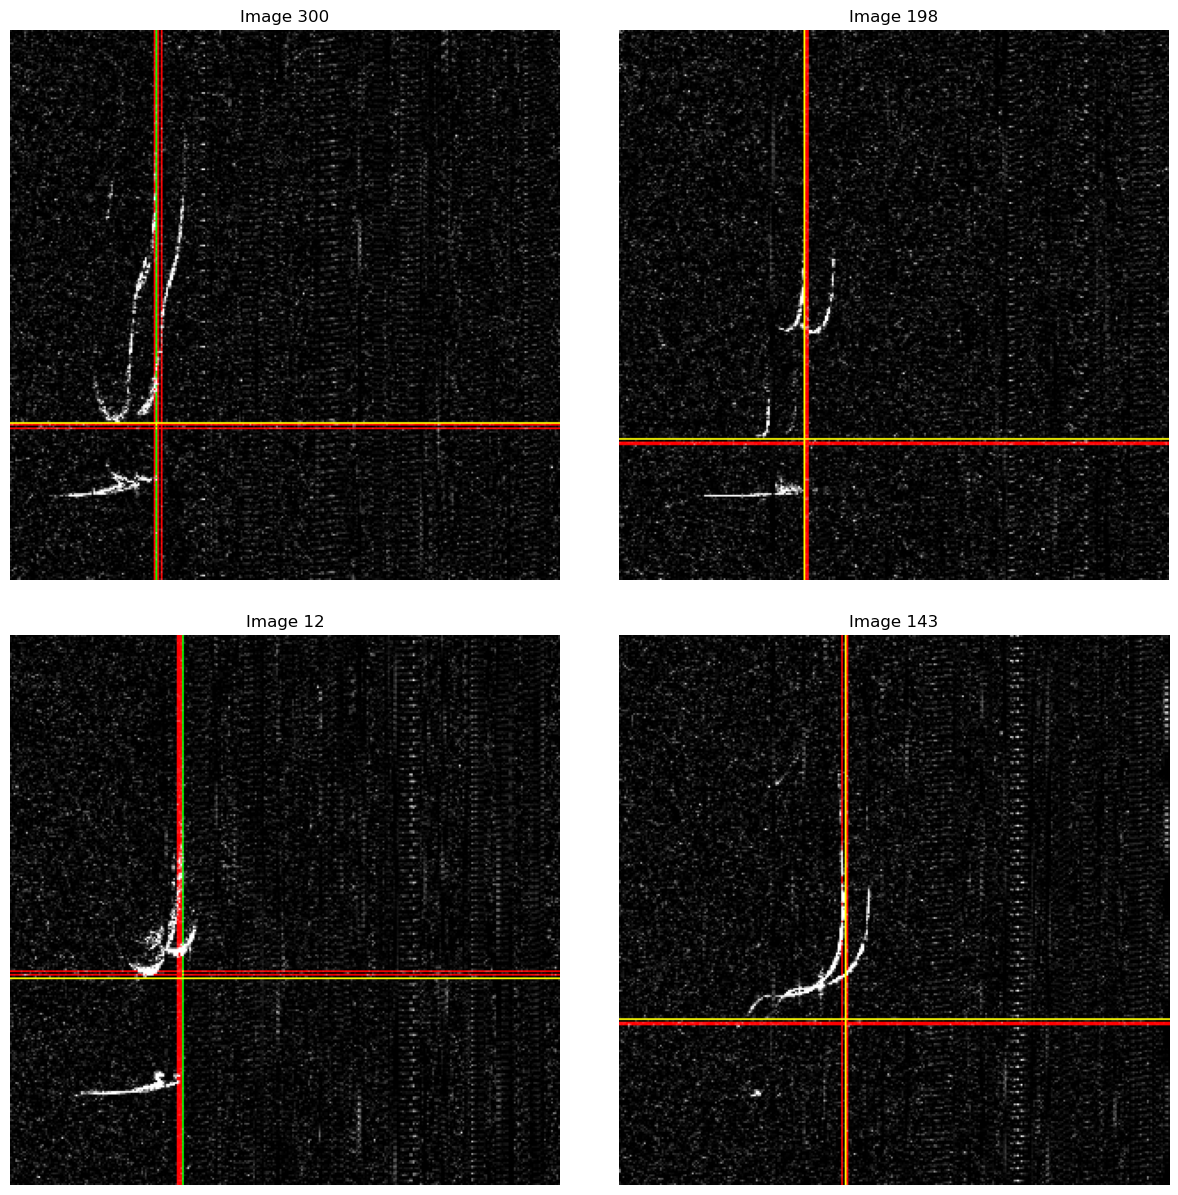

In [18]:
# This code visualizes 4 randomly selected test images, overlaying them with horizontal and vertical lines 
# representing the true and predicted values for certain parameters, where the true values are marked
# in green and the predictions in red. 

def draw_colored_lines_on_image(image, horizontal, vertical, std_horizontal, std_vertical, color='r'):
    """
    Draws horizontal and vertical colored lines on the image, along with thinner standard deviation lines.
    """
    # Convert grayscale to RGB if necessary
    if len(image.shape) == 2 or image.shape[2] == 1:
        image_rgb = np.stack((image.squeeze(),) * 3, axis=-1)
    else:
        image_rgb = np.copy(image)

    # Define line color
    line_color = [1, 0, 0] if color == 'r' else [0, 1, 0]  # Red for prediction, Green for true value

    # Draw main lines (thicker)
    image_rgb[int(horizontal), :] = line_color
    image_rgb[:, int(vertical)] = line_color

    # Draw standard deviation lines (thinner)
    if color == 'r':  # Only for predictions
        std_color = [1, 0, 0]  # Red color
        upper_horizontal, lower_horizontal = int(horizontal + std_horizontal), int(horizontal - std_horizontal)
        upper_vertical, lower_vertical = int(vertical + std_vertical), int(vertical - std_vertical)

        # Single pixel line for standard deviation
        image_rgb[upper_horizontal, :] = std_color
        image_rgb[lower_horizontal, :] = std_color
        image_rgb[:, upper_vertical] = std_color
        image_rgb[:, lower_vertical] = std_color

    return image_rgb

# Select 9 random images and their labels from the test set
indices = random.sample(range(len(X_test)), 4)
sample_images = X_test[indices]
sample_labels = y_test[indices]
sample_predictions = median_predictions[indices]

# Calculate standard deviations for predictions
std_predictions = np.std(predictions_array, axis=0)
std_predictions_vertical = std_predictions[:, 0]
std_predictions_horizontal = std_predictions[:, 1]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    # Original image flipped vertically
    img = np.flipud(sample_images[i].squeeze())  # Remove channel dimension and flip
    
    # Get standard deviations for the current sample
    std_pred_horizontal = std_predictions_horizontal[indices[i]]
    std_pred_vertical = std_predictions_vertical[indices[i]]

    # Get true and predicted values, adjusted for the flipped image
    true_vertical, true_horizontal = sample_labels[i]  # Swap the order here
    true_horizontal = img.shape[0] - true_horizontal  # Adjust for flipping
    pred_vertical, pred_horizontal = sample_predictions[i]  # Swap the order here
    pred_horizontal = img.shape[0] - pred_horizontal  # Adjust for flipping

    # Draw lines including standard deviations
    img_with_pred_lines = draw_colored_lines_on_image(img, pred_horizontal, pred_vertical, std_pred_horizontal, std_pred_vertical, color='r')
    img_with_true_lines = draw_colored_lines_on_image(img, true_horizontal, true_vertical, 0, 0, color='g')

    # Combine images with true and predicted lines
    combined_img = np.maximum(img_with_true_lines, img_with_pred_lines)

    # Display the image with lines
    ax.imshow(combined_img, cmap='gray')
    ax.set_title(f"Image {indices[i]}")
    ax.axis('off')

plt.show()
